In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf


In [43]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")


In [91]:
y_dt = train_df.values[:1024,0]
y_dt = y_dt.reshape(y_dt.shape[0],1)
x_dt = train_df.values[:1024,1:]

In [92]:
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder(categorical_features=[0])
Y_ = onehotencoder.fit_transform(y_dt).toarray()

print("Output shape : ",x_dt.shape)

Output shape :  (1024, 784)


In [93]:
learning_rate = 0.0001
iteration = 100
batch_size = 20
display_step = 10
dropout = 0.75

In [103]:
x = tf.placeholder(tf.float32,[None,x_dt.shape[1]])
y = tf.placeholder(tf.float32,[None,Y_.shape[1]])
keep_probability = tf.placeholder(tf.float32)

weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, 10]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([10]))
}

In [108]:
def conv(x,W,b,stride):
    x=tf.nn.conv2d(x,W,strides = [1,stride,stride,1],padding = 'SAME')
    x=tf.nn.bias_add(x,b)
    return tf.nn.relu(x)

def max_pool(x,stride):
    return tf.nn.max_pool(x,ksize = [1,stride,stride,1],strides = [1,stride,stride,1],padding='SAME')


def covolution_net(x,weights,biases,dropout):
    
    x = tf.reshape(x,shape = [-1,28,28,1])
    
    conv1 = conv(x,weights['wc1'],biases['bc1'],1)
    print("Convolution 1 : ",conv1.shape)
    max_pool1 = max_pool(conv1,2)
    
    print("Max Pool 1 : ",max_pool1.shape)
    
    conv2 = conv(max_pool1,weights['wc2'],biases['bc2'],1)
    print("Convolution 2 : ",conv2.shape)
    max_pool2 = max_pool(conv2,2)
    print("Max Pool 2 : ",max_pool2.shape)
    
    fc1 = tf.reshape(max_pool2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)
    print("Full Connected: ",fc1.shape)
    
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    print("Output: ",out.shape)
    return out




In [109]:
# Construct model
pred = covolution_net(x, weights, biases, dropout)

# Define loss and optimizer
logits = pred
labels = y
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Convolution 1 :  (?, 28, 28, 32)
Max Pool 1 :  (?, 14, 14, 32)
Convolution 2 :  (?, 14, 14, 64)
Max Pool 2 :  (?, 7, 7, 64)
Full Connected:  (?, 1024)
Output:  (?, 10)


In [110]:
print(Y_.shape)

(1024, 10)


Cost at  0  :  2.28852e+07
Cost at  1  :  2.19673e+07
Cost at  2  :  2.13933e+07
Cost at  3  :  2.07617e+07
Cost at  4  :  2.01692e+07
Cost at  5  :  1.93109e+07
Cost at  6  :  1.89087e+07
Cost at  7  :  1.89732e+07
Cost at  8  :  1.8582e+07
Cost at  9  :  1.8165e+07


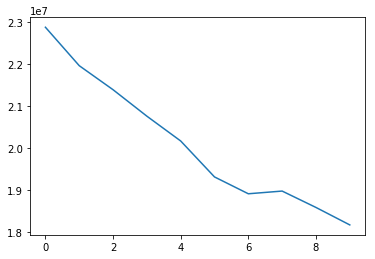

In [112]:
cost_each_iteration =[]
epoch_cost = 0.

init = tf.global_variables_initializer()


with tf.Session() as sess:
    sess.run(init)
    for i in range(10):
        _,epoch_cost = sess.run([optimizer, cost], feed_dict={x: x_dt, y: Y_ })
        cost_each_iteration.append(epoch_cost)
        print("Cost at ",i," : ",epoch_cost)


plt.plot(cost_each_iteration)
plt.show()